In [1]:
import cobra
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('/projectnb/cometsfba/pythonlibs/lib/python3.8/site-packages')

import cometspy_virus_test as c
    
covid_cobra = cobra.io.read_sbml_model('../Models/iAB_AMO1410_SARS-CoV-2.xml')
vbof = covid_cobra.reactions[3393]
    
#Note that the coefficient file leaves the ATP coefficient as 0
coefficientFile = open('../Models/Coefficients.txt')
new_coefficients = eval(coefficientFile.readline())
old_coefficients = eval(coefficientFile.readline())

for m in vbof.metabolites:
    vbof.add_metabolites({m: new_coefficients[str(m)] - old_coefficients[str(m)]})
        
#Add the coefficent for ATP
atp_c = covid_cobra.metabolites[225]
vbof.add_metabolites({atp_c: -23.063351651177445})

#Define the metabolites for lipids in the viral membrane
sphmyln = covid_cobra.metabolites[1535]
pchol = covid_cobra.metabolites[1528]

#Add these lipids to the VBOF (both primary and secondary) according to calculated coefficients
vbof.add_metabolites({sphmyln: -0.20233837286384723, pchol: -0.20233837286384723})

Using license file /usr/local/gurobi/gurobi.lic
Set parameter TokenServer to value sccsvc


In [3]:
targets = [1807, 2305, 2376, 2630, 3085]
maxflux = {}

solution = cobra.flux_analysis.pfba(covid_cobra)

for r in targets:
    rxn = covid_cobra.reactions[r]
    maxflux[r] = solution.fluxes[rxn._id]
    
maxflux['VBOF'] = solution.fluxes['VBOF']

In [5]:
kfluxes = []

for r in targets:
    rxn = covid_cobra.reactions[r]
    
    lb = rxn.lower_bound
    rb = rxn.upper_bound
    
    rxn.upper_bound = 0.5 * maxflux[r]
    
    solution = cobra.flux_analysis.pfba(covid_cobra)
    
    kfluxes.append((rxn._id, solution.fluxes['VBOF'], solution.fluxes['VBOF'] / maxflux['VBOF']))
    
    rxn.lower_bound = lb
    rxn.upper_bound = rb
    
kfluxes

[('GK1', 0.009343659936675288, 0.5),
 ('METS', 0.015551970892107067, 0.8322205108869177),
 ('MTHFR3', 0.015551970892107067, 0.8322205108869177),
 ('PCHOL_HStg', 0.009343659936675288, 0.5),
 ('SPHMYLNtg', 0.009343659936675288, 0.5)]

In [6]:


for r in targets:
    rxn = covid_cobra.reactions[r]
    
    lb = rxn.lower_bound
    rb = rxn.upper_bound
    
    rxn.upper_bound = 0.1 * maxflux[r]
    
    solution = cobra.flux_analysis.pfba(covid_cobra)
    
    kfluxes.append((rxn._id, solution.fluxes['VBOF'], solution.fluxes['VBOF'] / maxflux['VBOF']))
    
    rxn.lower_bound = lb
    rxn.upper_bound = rb
    
kfluxes

[('GK1', 0.009343659936675288, 0.5),
 ('METS', 0.015551970892107067, 0.8322205108869177),
 ('MTHFR3', 0.015551970892107067, 0.8322205108869177),
 ('PCHOL_HStg', 0.009343659936675288, 0.5),
 ('SPHMYLNtg', 0.009343659936675288, 0.5),
 ('GK1', 0.0018687319873350577, 0.1),
 ('METS', 0.00931154993177603, 0.49828172230598733),
 ('MTHFR3', 0.00931154993177603, 0.49828172230598733),
 ('PCHOL_HStg', 0.0018687319873350577, 0.1),
 ('SPHMYLNtg', 0.0018687319873350577, 0.1)]

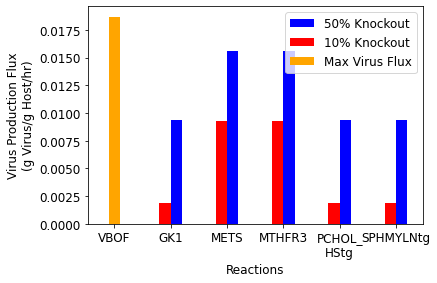

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 12

x = np.arange(6)
width = 0.2

# plot data in grouped manner of bar type
plt.bar(x+0.1, [0] + [t[1] for t in kfluxes[:5]], width, color='blue')
plt.bar(x-0.1, [0] + [t[1] for t in kfluxes[5:]], width, color='red')
plt.bar(x, [maxflux['VBOF']] + [0 for i in range(5)], width, color='orange')

plt.xticks(x, ['VBOF', 'GK1', 'METS', 'MTHFR3', 'PCHOL_\nHStg', 'SPHMYLNtg'])
plt.xlabel("Reactions")
plt.ylabel("Virus Production Flux\n(g Virus/g Host/hr)")
plt.legend(["50% Knockout", "10% Knockout", "Max Virus Flux"])
plt.show()